# Regresión Lineal

## Importación de librerías

In [1]:
#Librerías generales
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

import matplotlib.pyplot as plt
import scipy.stats as st

In [2]:
# Carga de datos
def load_titanic():
    try:
        import seaborn as sns
        df = sns.load_dataset('titanic')
        source = "seaborn"
    except Exception:
        # Ajusta el nombre de tu CSV si es distinto
        df = pd.read_csv("Titanic-Dataset.csv")
        source = "csv_local"
    return df, source

df_raw, source = load_titanic()
print(f"Fuente de datos: {source}")
df_raw.head()

Fuente de datos: seaborn


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [3]:
# Homologar columnas y target
df = df_raw.copy()

candidate = []

for c in ['pclass', 'sex', 'age', 'sibsp', 'parch', 'embarked','class', 'who', 'adult_male', 'alone']:
    if c in df.columns:
        candidate.append(c)

data =  df[candidate + ['fare']].copy()
print(f"Columnas usadas: {candidate + ['fare']}")
data.sample(5)

Columnas usadas: ['pclass', 'sex', 'age', 'sibsp', 'parch', 'embarked', 'class', 'who', 'adult_male', 'alone', 'fare']


,pclass,sex,age,sibsp,parch,embarked,class,who,adult_male,alone,fare
10,3,female,4.0,1,1,S,Third,child,False,False,16.7000
324,3,male,NaN,8,2,S,Third,man,True,False,69.5500
815,1,male,NaN,0,0,S,First,man,True,True,0.0000
376,3,female,22.0,0,0,S,Third,woman,False,True,7.2500
100,3,female,28.0,0,0,S,Third,woman,False,True,7.8958


## Feature engeenring

In [4]:
# FamilySize: tamaño de la familia (incluye a la persona)
if all(c in data.columns for c in ['sibsp','parch']):
    data['familysize'] = data['sibsp'].fillna(0) + data['parch'].fillna(0) + 1

# Age bins: discretización de edad (puede capturar efectos no lineales)
if 'age' in data.columns:
    bins = [-np.inf, 12, 18, 35, 55, np.inf]
    labels = ['child','teen','young_adult','adult','senior']
    data['age_group'] = pd.cut(data['age'], bins=bins, labels=labels)

# Interacción 'pclass x sex' (socioeconómico + género)
if all(c in data.columns for c in ['pclass','sex']):
    data['pclass_sex'] = data['pclass'].astype(str) + "_" + data['sex'].astype(str)

# Vista rápida
data.head()

,pclass,sex,age,sibsp,parch,embarked,class,who,adult_male,alone,fare,familysize,age_group,pclass_sex
0,3,male,22.0,1,0,S,Third,man,True,False,7.2500,2,young_adult,3_male
1,1,female,38.0,1,0,C,First,woman,False,False,71.2833,2,adult,1_female
2,3,female,26.0,0,0,S,Third,woman,False,True,7.9250,1,young_adult,3_female
3,1,female,35.0,1,0,S,First,woman,False,False,53.1000,2,young_adult,1_female
4,3,male,35.0,0,0,S,Third,man,True,True,8.0500,1,young_adult,3_male


In [5]:
# Preparación de X y y
target = 'fare'

num_features = [c for c in ['age','sibsp','parch','familysize'] if c in data.columns]
cat_features = [c for c in ['sex','embarked','embark_town','pclass','class','who','adult_male','alone','age_group','pclass_sex'] if c in data.columns]

X = data[num_features + cat_features].copy()
y = data[target].copy()

print("Numéricas:", num_features)
print("Categóricas:", cat_features)
print("Dimensiones X/y:", X.shape, y.shape)

Numéricas: ['age', 'sibsp', 'parch', 'familysize']
Categóricas: ['sex', 'embarked', 'pclass', 'class', 'who', 'adult_male', 'alone', 'age_group', 'pclass_sex']
Dimensiones X/y: (891, 13) (891,)


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((712, 13), (179, 13), (712,), (179,))

In [7]:
from sklearn import set_config
set_config(transform_output="pandas")  # para obtener DataFrame tras transform (scikit-learn >=1.2)

numeric_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocess = ColumnTransformer(transformers=[
    ("num", numeric_pipeline, num_features),
    ("cat", categorical_pipeline, cat_features)
])

# Fit transform para tener matrices listas (esto NO incluye el modelo, solo transformaciones)
X_train_prep = preprocess.fit_transform(X_train)
X_test_prep  = preprocess.transform(X_test)

print("Shapes post-prepro:", X_train_prep.shape, X_test_prep.shape)
X_train_prep.head(3)

Shapes post-prepro: (712, 33) (179, 33)


,num__age,num__sibsp,num__parch,num__familysize,cat__sex_female,cat__sex_male,cat__embarked_C,cat__embarked_Q,cat__embarked_S,cat__pclass_1,...,cat__age_group_child,cat__age_group_senior,cat__age_group_teen,cat__age_group_young_adult,cat__pclass_sex_1_female,cat__pclass_sex_1_male,cat__pclass_sex_2_female,cat__pclass_sex_2_male,cat__pclass_sex_3_female,cat__pclass_sex_3_male
331,1.253641,-0.470722,-0.479342,-0.554666,0.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
733,-0.477284,-0.470722,-0.479342,-0.554666,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
382,0.215086,-0.470722,-0.479342,-0.554666,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [8]:
# Sanity checks de tamaños y alineaciones
print("X_train_prep:", X_train_prep.shape)
print("y_train:", y_train.shape)
print("X_test_prep:", X_test_prep.shape)
print("y_test:", y_test.shape)

assert len(X_train_prep) == len(y_train), "Desalineación: X_train_prep y y_train"
assert len(X_test_prep)  == len(y_test),  "Desalineación: X_test_prep y y_test"


X_train_prep: (712, 33)
y_train: (712,)
X_test_prep: (179, 33)
y_test: (179,)


## Entranamiento 

In [14]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)
metrics = {}

def eval_and_store(name, model, Xtr, ytr, Xte, yte):
    model.fit(Xtr, ytr)
    pred = model.predict(Xte)
    
    r2 = r2_score(yte, pred) #Aquí estaba el error!!
    rmse = np.sqrt(mean_squared_error(yte, pred))
    mae = mean_absolute_error(yte, pred)

    metrics[name] = {"R2": r2, "RMSE": rmse, "MAE": mae}
    print(f"{name} - R2: {r2:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}")

    return model, pred

# Modelos
#OLS
ols = LinearRegression()
ols_model, ols_pred = eval_and_store("OLS", ols, X_train_prep, y_train, X_test_prep, y_test)

#Ridge Regression
ridge = RidgeCV(alphas=np.logspace(-3, 3, 13), cv=cv)
ridge_model, ridge_pred = eval_and_store("Ridge", ridge, X_train_prep, y_train, X_test_prep, y_test)

#Lasso Regression
lasso = LassoCV(alphas=np.logspace(-3, 3, 13), cv=cv, max_iter=5000)
lasso_model, lasso_pred = eval_and_store("Lasso", lasso, X_train_prep, y_train, X_test_prep, y_test)

#ElasticNet Regression tarea

OLS - R2: 0.4052, RMSE: 30.3387, MAE: 18.1627
Ridge - R2: 0.4482, RMSE: 29.2206, MAE: 16.9906
Lasso - R2: 0.4307, RMSE: 29.6816, MAE: 17.2207


## Validación cruzada

In [15]:
def cv_r2(model, X, y, cv):
    scores = cross_val_score(model, X, y, cv=cv, scoring="r2", n_jobs=-1)
    return scores.mean(), scores.std()

cv_scores = {}
for name, mdl in [("OLS", LinearRegression()),
                  ("RidgeCV", RidgeCV(alphas=np.logspace(-3,3,25), cv=cv)),
                  ("LassoCV", LassoCV(cv=cv, random_state=42, max_iter=5000))]:
    # OJO: estos modelos esperan X ya preprocesado
    m, s = cv_r2(mdl, X_train_prep, y_train, cv)
    cv_scores[name] = {"R2_CV_mean": m, "R2_CV_std": s}

pd.DataFrame(cv_scores).T.sort_values("R2_CV_mean", ascending=False)

,R2_CV_mean,R2_CV_std
LassoCV,0.481260,0.113039
RidgeCV,0.475673,0.108513
OLS,0.471101,0.108925


## Residuos análisis

Mejor modelo (por R² test): Ridge


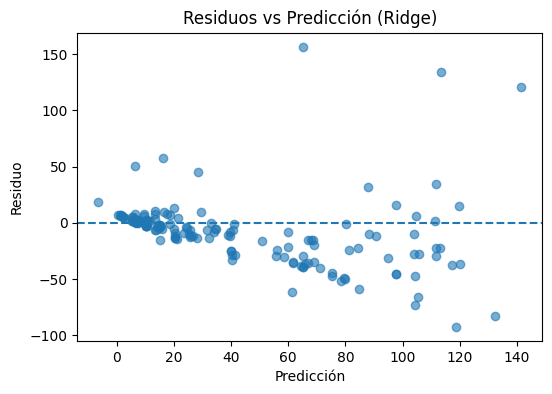

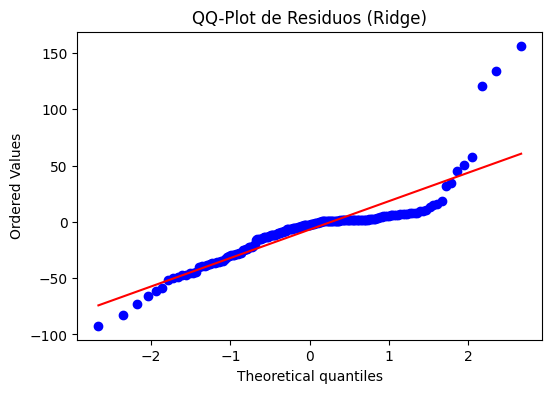

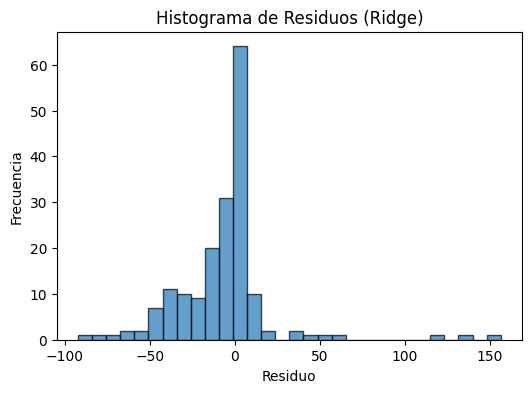

In [17]:
best_name = max(metrics, key=lambda k: metrics[k]["R2"])
print("Mejor modelo (por R² test):", best_name)

best_model = {"OLS": ols_model, "Ridge": ridge_model, "Lasso": lasso_model}[best_name]
best_pred = {"OLS": ols_pred, "Ridge": ridge_pred, "Lasso": lasso_pred}[best_name]

residuals = y_test - best_pred

# 9.1 Plot Residuals vs Predicted (homocedasticidad)
plt.figure(figsize=(6,4))
plt.scatter(best_pred, residuals, alpha=0.6)
plt.axhline(0, linestyle="--")
plt.xlabel("Predicción")
plt.ylabel("Residuo")
plt.title(f"Residuos vs Predicción ({best_name})")
plt.show()

# 9.2 QQ-Plot (normalidad de residuos)
plt.figure(figsize=(6,4))
st.probplot(residuals, dist="norm", plot=plt)
plt.title(f"QQ-Plot de Residuos ({best_name})")
plt.show()

# 9.3 Histograma de residuos
plt.figure(figsize=(6,4))
plt.hist(residuals, bins=30, edgecolor="k", alpha=0.7)
plt.title(f"Histograma de Residuos ({best_name})")
plt.xlabel("Residuo")
plt.ylabel("Frecuencia")
plt.show()